# Inference: Haario-Bardenet adaptive covariance MCMC

This example shows you how to perform Bayesian inference on a time series, using a variant of [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc_remi.html) detailed in supplementary materials of [1].

[1] Uncertainty and variability in models of the cardiac action potential:
    Can we build trustworthy models?
    Johnstone, Chang, Bardenet, de Boer, Gavaghan, Pathmanathan, Clayton,
    Mirams (2015) Journal of Molecular and Cellular Cardiology

It follows on from the [first sampling example](./sampling-first-example.ipynb).

Running...
Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0.5       0.5        0:00.1
2     9      0         0.333     0.333      0:00.1
3     12     0         0.25      0.25       0:00.1
20    63     0.0476    0.0952    0.0952     0:00.1
40    123    0.0976    0.0732    0.0488     0:00.1
60    183    0.082     0.0656    0.0328     0:00.1
80    243    0.0741    0.0617    0.0247     0:00.2
100   303    0.0792    0.0495    0.0297     0:00.2
120   363    0.0661    0.0413    0.0248     0:00.3
140   423    0.0638    0.0426    0.0213     0:00.3
160   483    0.0559    0.0373    0.0186     0:00.3
180   543    0.0497    0.0442    0.0166     0:00.3
200   603    0.0448    0.039801  0.0149     0:00.3
220   663    0.0452    0.0362    0.0136     0:00.3
240   723    0.0456    0.0332    0.0124     0:00.4
260   783    0.0421    0.0

3200  9603   0.19      0.178     0.185567   0:06.1
3220  9663   0.189     0.178     0.186588   0:06.2
3240  9723   0.189     0.178     0.187      0:06.2
3260  9783   0.19      0.179     0.188      0:06.2
3280  9843   0.191     0.179     0.188      0:06.3
3300  9903   0.191     0.18      0.188      0:06.3
3320  9963   0.191     0.179     0.189      0:06.3
3340  10023  0.192     0.18      0.189      0:06.4
3360  10083  0.192     0.181     0.188      0:06.4
3380  10143  0.191955  0.181     0.189      0:06.5
3400  10203  0.193     0.182     0.188474   0:06.5
3420  10263  0.192926  0.183     0.189      0:06.6
3440  10323  0.193     0.183     0.189      0:06.6
3460  10383  0.192     0.183     0.189      0:06.6
3480  10443  0.192     0.183     0.189      0:06.7
3500  10503  0.193     0.183     0.191      0:06.7
3520  10563  0.193     0.184     0.192      0:06.8
3540  10623  0.193     0.184     0.191      0:06.8
3560  10683  0.193     0.185     0.192      0:06.8
3580  10743  0.193     0.184   

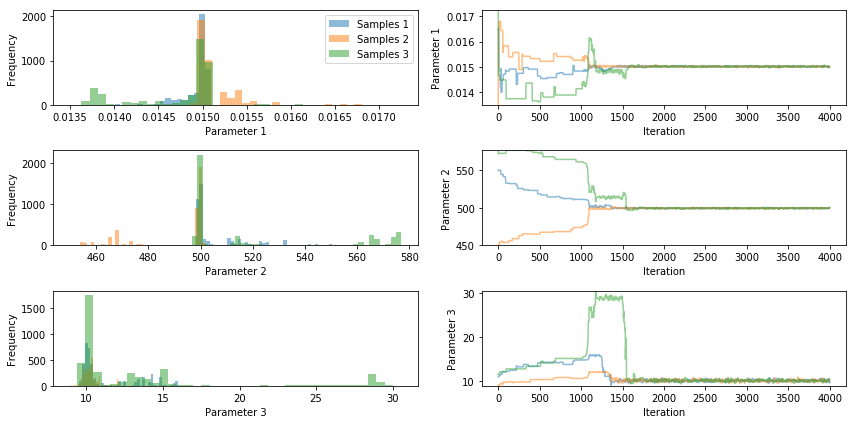

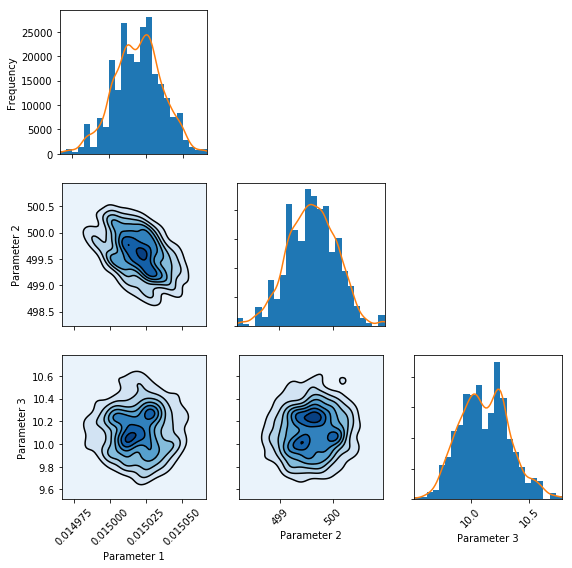

In [1]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise*0.1],
    [0.02, 600, noise*100]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 1.1,
    real_parameters * 0.9,
    real_parameters * 1.15,
]

# Create mcmc routine with four chains
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.HaarioBardenetACMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(1000)

# Disable logging mode
mcmc.set_log_to_screen(True)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True)

# Show graphs
plt.show()